# Diff Drive MPC Controller Example

## System model

The state of a diff drive vehicle can be expressed as:

$$
\mathbf{x} = 
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}
$$

And the input is given as:

$$
\mathbf{u} = 
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
$$

Hence for a dynamical system:
$$
\mathbf{\dot{x}} = f(\mathbf{x}, \mathbf{u})
$$

The corresponding diff drive system can be expressed as:
$$
\mathbf{\dot{x}} = 
\begin{bmatrix}
cos(\theta) & 0 \\
sin(\theta) & 0 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
v \\
\omega \\
\end{bmatrix}
$$

The discrete version of this system can be expressed as:

$$
\mathbf{x_{k+1}} = f(\mathbf{x_k}, \mathbf{u_k}) = \mathbf{x_k} + dt 
\begin{bmatrix}
cos(\theta) & 0 \\
sin(\theta) & 0 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
v \\
\omega \\
\end{bmatrix}
$$

## Linearizing the system model
To be able to formulate the MPC problem, we need to linearize the system around a fixed point.

Considering a system that has the following formulation

$$
x_{k+1} = f(x_k, u_k)
$$

Linearizing about the point $x_{k}^{prev}, u_k^{prev}$ which the state and input from the previous update cycle.

$$
x_{k+1} = f(x_{k}^{prev}, u_k^{prev}) + \left. \frac{\partial f}{\partial x_k} \right|_{x_k = x_k^{prev}} (x_k - x_{k}^{prev}) + \left. \frac{\partial f}{\partial u_k} \right|_{u_k = u_k^{prev}} (u_k - u_k^{prev})
$$

Since $f(x_{k}^{prev}, u_k^{prev}) = x_{k+1}^{prev}$
Then we could re-arrange:

$$
x_{k+1} - x_{k+1}^{prev} = \left. \frac{\partial f}{\partial x_k} \right|_{x_k = x_k^{prev}} (x_k - x_{k}^{prev}) + \left. \frac{\partial f}{\partial u_k} \right|_{u_k = u_k^{prev}} (u_k - u_k^{prev})
$$

Letting:

$$
x_k - x_{k}^{prev} = \Delta x_k
$$

$$
u_k - u_k^{prev} = \Delta u_k
$$

$$
\left. \frac{\partial f}{\partial x_k}  \right|_{x_k = x_k^{prev}} = A_k^{prev}\ and\ \left. \frac{\partial f}{\partial u_k}  \right|_{u_k = u_k^{prev}} = B_k^{prev}
$$
We can then express the linearized system:

$$
\Delta x_{k+1} =  A_k^{prev} \Delta x_k + B_k^{prev} \Delta u_k
$$

Now defining the A & B matrices:

$$
A_k = 
\begin{bmatrix}
1 & 0 & -dt\ sin(\theta_k) v_k \\
0 & 1 & dt\ cost(\theta_k) v_k \\
0 & 0 & 1 
\end{bmatrix}
$$

$$
B_k = 
\begin{bmatrix}
dt cos(\theta_k) & 0 \\
dt sin(\theta_k) & 0 \\
0 & dt 
\end{bmatrix}
$$

## Formulating the MPC problem



In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def rollout_unicycle(x0, U, dt):
    X = [x0.copy()]
    x, y, th = x0
    for v, w in U:
        x = x + dt * v * np.cos(th)
        y = y + dt * v * np.sin(th)
        th = th + dt * w
        X.append(np.array([x, y, th]))
    return np.array(X)

rollout_unicycle([0, 0, 0], [[0.5, 0]], 0.1)

array([[0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  ]])

In [3]:
import numpy as np
from matplotlib.patches import Polygon

def get_robot_corners(x, y, theta, length=0.3, width=0.2):
    """
    Returns the 4 corners of a rectangle centered at (x,y) with orientation theta
    length = along the forward direction
    width = lateral width
    """
    # half sizes
    l2, w2 = length/2, width/2
    
    # corners in robot frame (front-left, front-right, rear-right, rear-left)
    corners = np.array([
        [l2, w2],
        [l2, -w2],
        [-l2, -w2],
        [-l2, w2],
    ])
    
    # rotation matrix
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    
    # rotate and translate
    corners = (R @ corners.T).T
    corners[:,0] += x
    corners[:,1] += y
    
    return corners

In [4]:
def linearize_along_traj(X, U, dt):
    """
    Linearize unicycle around (X_k, U_k).
    Returns A_k (3x3) and B_k (3x2) for k = 0..N-1.
    """
    N = len(U)
    A = []
    B = []
    for k in range(N):
        x, y, th = X[k]
        v, w = U[k]
        A_k = np.eye(3)
        A_k[0,2] = -dt * v * np.sin(th)  # d(x_next)/d(th)
        A_k[1,2] =  dt * v * np.cos(th)  # d(y_next)/d(th)

        B_k = np.zeros((3,2))
        B_k[0,0] = dt * np.cos(th)       # d(x_next)/d(v)
        B_k[1,0] = dt * np.sin(th)       # d(y_next)/d(v)
        B_k[2,1] = dt                     # d(th_next)/d(w)

        A.append(A_k); B.append(B_k)
    return A, B

In [108]:
%matplotlib inline
from IPython.display import clear_output, display
# Obstacle parameters
ox, oy, r = 1.0, -0.2, 0.5
alpha = 5.0   # CBF rate

class DiffDriveMPC:
    def __init__(self, N=15, dt=0.1,
                 Q=np.diag([5.0, 5.0, 0.2]),
                 R=np.diag([0.1, 0.1]),
                 QN=np.diag([10.0, 10.0, 0.5]),
                 v_bounds=(-0.3, 0.8),
                 w_bounds=(-2.5, 2.5),
                 dv_bounds=(-0.5, 0.5),
                 dw_bounds=(-0.2, 0.2)):
        self.N, self.dt = N, dt
        self.Q, self.R, self.QN = Q, R, QN
        self.vmin, self.vmax = v_bounds
        self.wmin, self.wmax = w_bounds
        self.dvmin, self.dvmax = dv_bounds
        self.dwmin, self.dwmax = dw_bounds

    def solve(self, x0, ref_traj, U_init=None, iters=3):
        """
        ref_traj: array of shape (N+1, 3) with desired [x,y,th] over horizon.
        U_init: initial guess (N,2) for [v,w]; if None, zeros.
        iters: sequential linearization iterations (1–3 usually enough).
        Returns (U*, X*) for the first iteration’s solution after refinement.
        """
        def make_sdf(x, y):
            dx = x - ox
            dy = y - oy
            return np.sqrt(dx**2 + dy**2) - r
        
        def grad_sdf(x, y):
            norm = np.sqrt((x - ox)**2 + (y - oy)**2)
            return np.array([(x - ox) / norm, (y - oy) / norm])
        
        N, dt = self.N, self.dt
        if U_init is None:
            U = np.zeros((N,2))
        else:
            U = U_init.copy()

        X = rollout_unicycle(x0, U, dt)

        for _ in range(iters):
            # Linearize around current (X,U)
            A_list, B_list = linearize_along_traj(X, U, dt)

            # Decision variables: deviations (dx, du) around (X,U)
            dx = cp.Variable((N+1, 3))
            du = cp.Variable((N, 2))

            # Cost
            cost = 0
            # Constraints
            cons = []
            for k in range(N):
                xk = X[k] + dx[k]
                uk = U[k] + du[k]
                e = xk - ref_traj[k]
                cost += cp.quad_form(e, self.Q) + cp.quad_form(uk, self.R)
                xk_1 =  X[k + 1] + dx[k + 1]
                h = make_sdf(X[k][0],  X[k][1])
                grad_h = grad_sdf(X[k][0],  X[k][1])
                h_dot = grad_h[0] * dx[k][0] / dt + grad_h[1] * dx[k][1] / dt
                cbf_constraint = h_dot + alpha * h >= 0
                cons += [cbf_constraint]
            eN = (X[N] + dx[N]) - ref_traj[N]
            cost += cp.quad_form(eN, self.QN)


            # initial condition on deviation
            cons += [dx[0] == 0]

            # linearized dynamics: dx_{k+1} = A_k dx_k + B_k du_k + (f(X_k,U_k) - (A_k X_k + B_k U_k - X_k))
            # but simpler as deviation form around the true dynamics:
            for k in range(N):
                Ak, Bk = A_list[k], B_list[k]
                cons += [dx[k+1] == Ak @ dx[k] + Bk @ du[k]]

            # input bounds and rate bounds on actual inputs
            for k in range(N):
                uk = U[k] + du[k]
                cons += [
                    uk[0] >= self.vmin, uk[0] <= self.vmax,
                    uk[1] >= self.wmin, uk[1] <= self.wmax,
                ]
                if k > 0:
                    ukm1 = U[k-1] + du[k-1]
                    cons += [
                        uk[0] - ukm1[0] >= self.dvmin,
                        uk[0] - ukm1[0] <= self.dvmax,
                        uk[1] - ukm1[1] >= self.dwmin,
                        uk[1] - ukm1[1] <= self.dwmax,
                    ]

            prob = cp.Problem(cp.Minimize(cost), cons)
            prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                # If it didn't solve, break and return the last feasible guess.
                break

            dU = du.value
            U = U + dU
            X = rollout_unicycle(x0, U, dt)

        return U, X

# --- Demo: track a simple path (e.g., straight then turn) ---
np.random.seed(0)
dt = 0.1
N = 15
mpc = DiffDriveMPC(N=N, dt=dt)

# Build a reference trajectory: go to (2, 0), then turn to face pi/2
T_steps = 60
ref = np.zeros((T_steps+N+1, 3))
for k in range(T_steps+N+1):
    t = k*dt
    if t < 2.5:
        ref[k, :] = [0.8*t, 0.0, 0.0]
    else:
        ref[k, :] = [2.0, 0.0, min((t-2.5)*0.6, np.pi/2)]

x = np.array([0.0, 0.0, np.pi])
traj = [x.copy()]
U_log = []


fig, ax = plt.subplots()
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-1, 1.5)
ax.set_aspect('equal')

line_traj, = ax.plot([], [], 'b-', label='Trajectory')
line_plan, = ax.plot([], [], 'g--', label='MPC Plan')
ax.plot(ref[:,0], ref[:,1], '--', label='Reference')
circle = plt.Circle((ox, oy), r, color='r', alpha=0.3)
ax.add_patch(circle)
ax.legend()

# Robot initial pose
x0, y0, th0 = traj[0]
robot_patch = Polygon(get_robot_corners(x0, y0, th0), closed=True, color='blue', alpha=0.5)
ax.add_patch(robot_patch)

U_guess = None
for k in range(T_steps):
    ref_h = ref[k:k+N+1]            # horizon slice
    U_opt, X_pred = mpc.solve(x, ref_h, U_init=U_guess, iters=2)
    u0 = U_opt[0]
    U_log.append(u0)
    # apply first input to the true (nonlinear) system
    x = rollout_unicycle(x, [u0], dt)[-1]
    traj.append(x)
    # warm-start next step with shifted control
    U_guess = np.vstack([U_opt[1:], U_opt[-1]])

    traj_array = np.array(traj)
      # update your data arrays
    line_traj.set_data(traj_array[:,0], traj_array[:,1])
    line_plan.set_data(X_pred[:,0], X_pred[:,1])

    # update robot box
    corners = get_robot_corners(x[0], x[1], x[2])
    robot_patch.set_xy(corners)
    
    # redraw the same figure
    display(fig)
    plt.pause(0.001)
    clear_output(wait=True)  # requires from IPython.display import clear_output, display

traj = np.array(traj)
U_log = np.array(U_log)

# Plot
plt.figure()
circle = plt.Circle((ox, oy), r, color='r', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)
plt.plot(ref[:T_steps+1,0], ref[:T_steps+1,1], '--', label='reference')
plt.plot(traj[:,0], traj[:,1], '-', label='trajectory')
plt.axis('equal'); plt.legend(); plt.title('MPC tracking (diff drive)')
plt.xlabel('x [m]'); plt.ylabel('y [m]'); plt.show()

plt.figure()
plt.step(np.arange(T_steps)*dt, U_log[:,0], where='post', label='v [m/s]')
plt.step(np.arange(T_steps)*dt, U_log[:,1], where='post', label='omega [rad/s]')
plt.title('Controls'); plt.xlabel('time [s]'); plt.legend(); plt.show()

KeyboardInterrupt: 

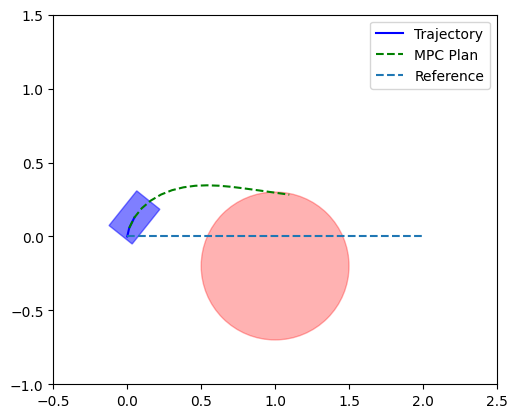

In [ ]:

%matplotlib inline
from IPython.display import clear_output, display
# Obstacle parameters
ox, oy, r = 1.0, -0.2, 0.5
alpha = 5.0   # CBF rate

class DiffDriveMPC:
    def __init__(self, N=15, dt=0.1,
                 Q=np.diag([10.0, 10.0, 0.2]),
                 R=np.diag([0.1, 0.1]),
                 QN=np.diag([10.0, 10.0, 0.5]),
                 v_bounds=(-0.0, 0.8),
                 w_bounds=(-2.5, 2.5),
                 dv_bounds=(-0.5, 0.5),
                 dw_bounds=(-0.2, 0.2)):
        self.N, self.dt = N, dt
        self.Q, self.R, self.QN = Q, R, QN
        self.vmin, self.vmax = v_bounds
        self.wmin, self.wmax = w_bounds
        self.dvmin, self.dvmax = dv_bounds
        self.dwmin, self.dwmax = dw_bounds

    def solve(self, x0, ref_traj, U_init=None, iters=3):
        """
        ref_traj: array of shape (N+1, 3) with desired [x,y,th] over horizon.
        U_init: initial guess (N,2) for [v,w]; if None, zeros.
        iters: sequential linearization iterations (1–3 usually enough).
        Returns (U*, X*) for the first iteration’s solution after refinement.
        """
        def make_sdf(x, y):
            dx = x - ox
            dy = y - oy
            return np.sqrt(dx**2 + dy**2) - r
        
        def grad_sdf(x, y):
            norm = np.sqrt((x - ox)**2 + (y - oy)**2)
            return np.array([(x - ox) / norm, (y - oy) / norm])
        
        N, dt = self.N, self.dt
        if U_init is None:
            U = np.zeros((N,2))
        else:
            U = U_init.copy()

        X = rollout_unicycle(x0, U, dt)

        for _ in range(iters):
            # Linearize around current (X,U)
            A_list, B_list = linearize_along_traj(X, U, dt)

            # Decision variables: deviations (dx, du) around (X,U)
            dx = cp.Variable((N+1, 3))
            du = cp.Variable((N, 2))

            # Cost
            cost = 0
            # Constraints
            cons = []
            X_final = x0
            for k in range(N):
                xk = X[k] + dx[k]
                uk = U[k] + du[k]
                e = xk - ref_traj[k]
                cost += cp.quad_form(uk, self.R)
                xk_1 =  X[k + 1] + dx[k + 1]
                h = make_sdf(X[k][0],  X[k][1])
                grad_h = grad_sdf(X[k][0],  X[k][1])
                h_dot = grad_h[0] * dx[k][0] / dt + grad_h[1] * dx[k][1] / dt
                cbf_constraint = h_dot + alpha * h >= 0
                cons += [cbf_constraint]
            eN = (X[N] + dx[N]) - ref_traj[N]
            cost += cp.quad_form(eN, self.QN)


            # initial condition on deviation
            cons += [dx[0] == 0]

            # linearized dynamics: dx_{k+1} = A_k dx_k + B_k du_k + (f(X_k,U_k) - (A_k X_k + B_k U_k - X_k))
            # but simpler as deviation form around the true dynamics:
            for k in range(N):
                Ak, Bk = A_list[k], B_list[k]
                cons += [dx[k+1] == Ak @ dx[k] + Bk @ du[k]]

            # input bounds and rate bounds on actual inputs
            for k in range(N):
                uk = U[k] + du[k]
                cons += [
                    uk[0] >= self.vmin, uk[0] <= self.vmax,
                    uk[1] >= self.wmin, uk[1] <= self.wmax,
                ]
                if k > 0:
                    ukm1 = U[k-1] + du[k-1]
                    cons += [
                        uk[0] - ukm1[0] >= self.dvmin,
                        uk[0] - ukm1[0] <= self.dvmax,
                        uk[1] - ukm1[1] >= self.dwmin,
                        uk[1] - ukm1[1] <= self.dwmax,
                    ]

            prob = cp.Problem(cp.Minimize(cost), cons)
            prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                # If it didn't solve, break and return the last feasible guess.
                break

            dU = du.value
            U = U + dU
            X = rollout_unicycle(x0, U, dt)

        return U, X

# --- Demo: track a simple path (e.g., straight then turn) ---
np.random.seed(0)
dt = 0.1
N = 15
mpc = DiffDriveMPC(N=N, dt=dt)

# Build a reference trajectory: go to (2, 0), then turn to face pi/2
T_steps = 60
ref = np.zeros((T_steps+N+1, 3))
for k in range(T_steps+N+1):
    t = k*dt
    if t < 2.5:
        ref[k, :] = [0.8*t, 0.0, 0.0]
    else:
        ref[k, :] = [2.0, 0.0, min((t-2.5)*0.6, np.pi/2)]

x = np.array([0.0, 0.0, np.pi])
traj = [x.copy()]
U_log = []


fig, ax = plt.subplots()
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-1, 1.5)
ax.set_aspect('equal')

line_traj, = ax.plot([], [], 'b-', label='Trajectory')
line_plan, = ax.plot([], [], 'g--', label='MPC Plan')
ax.plot(ref[:,0], ref[:,1], '--', label='Reference')
circle = plt.Circle((ox, oy), r, color='r', alpha=0.3)
ax.add_patch(circle)
ax.legend()

# Robot initial pose
x0, y0, th0 = traj[0]
robot_patch = Polygon(get_robot_corners(x0, y0, th0), closed=True, color='blue', alpha=0.5)
ax.add_patch(robot_patch)

U_guess = None
for k in range(T_steps):
    ref_h = ref[k:k+N+1]            # horizon slice
    U_opt, X_pred = mpc.solve(x, ref_h, U_init=U_guess, iters=2)
    u0 = U_opt[0]
    U_log.append(u0)
    # apply first input to the true (nonlinear) system
    x = rollout_unicycle(x, [u0], dt)[-1]
    traj.append(x)
    # warm-start next step with shifted control
    U_guess = np.vstack([U_opt[1:], U_opt[-1]])

    traj_array = np.array(traj)
      # update your data arrays
    line_traj.set_data(traj_array[:,0], traj_array[:,1])
    line_plan.set_data(X_pred[:,0], X_pred[:,1])

    # update robot box
    corners = get_robot_corners(x[0], x[1], x[2])
    robot_patch.set_xy(corners)
    
    # redraw the same figure
    display(fig)
    plt.pause(0.001)
    clear_output(wait=True)  # requires from IPython.display import clear_output, display

traj = np.array(traj)
U_log = np.array(U_log)

# Plot
plt.figure()
circle = plt.Circle((ox, oy), r, color='r', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)
plt.plot(ref[:T_steps+1,0], ref[:T_steps+1,1], '--', label='reference')
plt.plot(traj[:,0], traj[:,1], '-', label='trajectory')
plt.axis('equal'); plt.legend(); plt.title('MPC tracking (diff drive)')
plt.xlabel('x [m]'); plt.ylabel('y [m]'); plt.show()

plt.figure()
plt.step(np.arange(T_steps)*dt, U_log[:,0], where='post', label='v [m/s]')
plt.step(np.arange(T_steps)*dt, U_log[:,1], where='post', label='omega [rad/s]')
plt.title('Controls'); plt.xlabel('time [s]'); plt.legend(); plt.show()